In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regular expressions
import re

# LightGBM
import lightgbm as lgb

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV

In [2]:
trainRaw = pd.read_csv(r'C:\Users\20943\Desktop\我的坚果云\Sys_learning\5_\titanic\train.csv')
testRaw = pd.read_csv(r'C:\Users\20943\Desktop\我的坚果云\Sys_learning\5_\titanic\test.csv')
trainRaw.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# And concatonate together
nTrain = trainRaw.shape[0]
full = pd.concat([trainRaw, testRaw],
                 axis=0)

In [3]:
trainRaw = pd.read_csv(r"C:\Users\Lenovo\Music\我的坚果云\Sys_learning\5_\titanic\train.csv")
testRaw = pd.read_csv(r"C:\Users\Lenovo\Music\我的坚果云\Sys_learning\5_\titanic\test.csv")

In [3]:
# And concatonate together
nTrain = trainRaw.shape[0]
full = pd.concat([trainRaw, testRaw],
                 axis=0)

In [4]:
def ADSplit(s):
    """
    Function to try and extract cabin letter and number from the cabin column.
    Runs a regular expression that finds letters and numbers in the
    string. These are held in match.group, if they exist.
    """

    match = re.match(r"([a-z]+)([0-9]+)", s, re.I)

    try:
        letter = match.group(1)
    except:
        letter = ''

    try:
        number = match.group(2)
    except:
        number = 9999

    return letter, number

In [5]:
def DR(s):
    """
    From the cabin string, try and extract letter, number, and number of cabins
    """
    # Check contents
    if isinstance(s, (int, float)):
        # If field is empty, return nothing
        letter = ''
        number = ''
        nRooms = 9999
    else:
        # If field isn't empty, split sting on space. Some strings contain
        # multiple cabins.
        s = s.split(' ')
        # Count the cabins based on number of splits
        nRooms = len(s)
        # Just take first cabin for letter/number extraction
        s = s[0]

        letter, number = ADSplit(s)

    return [letter, number, nRooms]

In [8]:
# Apply DR function to each cell in Cabin column using pandas apply method.
out = full['Cabin'].apply(DR)
# Outout tuple with 3 values for each row, convert this to pandas df
out = out.apply(pd.Series)
# And name the columns
out.columns = ['CL', 'CN', 'nC']

# Then concatenate these columns to the dataset
full = pd.concat([full, out],
                 axis=1)

In [9]:
# %% Family
# Add some family features directly to new columns in the dataset

# Size
full['fSize'] = full['SibSp'] + full['Parch'] + 1
# Ratio
full['fRatio'] = (full['Parch'] + 1) / (full['SibSp'] + 1)
# Adult?
full['Adult'] = full['Age'] > 18

In [10]:
# Extract titles from Name column, standardise
titleDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Sir",
    "Don": "Sir",
    "Sir": "Sir",
    "Dr": "Dr",
    "Rev": "Rev",
    "theCountess": "Lady",
    "Dona": "Lady",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Lady"
}

In [11]:
def splitName(s, titleDict):
    """
    Extract title from name, replace with value in title dictionary. Also
    return surname.
    """

    # Remove '.' from name string
    s = s.replace('.', '')
    # Split on spaces
    s = s.split(' ')
    # get surname
    surname = s[0]

    # Get title - loop over titleDict, if s matches a key, take the
    # corresponding value as the title
    title = [t for k, t in titleDict.items() if str(k) in s]

    # If no matching keys in title dict, use 'Other'.
    if title == []:
        title = 'Other'
    else:
        # Title is a list, so extract contents
        title = title[0]

    # Return surname (stripping remaining ',') and title as string
    return surname.strip(','), title

In [12]:
# Apply functions to df and concatenate new columns as before
out = full['Name'].apply(splitName,
                         args=[titleDict])
out = out.apply(pd.Series)
out.columns = ['Surname', 'Title']

full = pd.concat([full, out],
                 axis=1)


# %% Categorical columns
# List of categorical columns to recode
catCols = ['Sex', 'Embarked', 'CL', 'CN', 'Surname', 'Title']

# Recode
for c in catCols:
    # Convert column to pd.Categotical
    full[c] = pd.Categorical(full[c])
    # Extract the cat.codes and replace the column with these
    full[c] = full[c].cat.codes
    # Convert the cat codes to categotical...
    full[c] = pd.Categorical(full[c])


# Generate a logical index of categorical columns to maybe use with LightGBM later
catCols = [i for i,v in enumerate(full.dtypes) if str(v)=='category']


In [13]:
#%% Age
# Replace missing age values with median.
# See ither kernels for more sophisticated ways of doing this!
full.loc[full.Age.isnull(), 'Age'] = np.median(full['Age'].loc[full.Age.notnull()])


#%% Split datasets
train = full.iloc[0:nTrain,:]
test = full.iloc[nTrain::,:]

In [14]:
#%% Prepare data
def prepLGB(data,
            classCol='',
            IDCol='',
            fDrop=[]):

        # Drop class column
        if classCol != '':
            labels = data[classCol]
            fDrop = fDrop + [classCol]
        else:
            labels = []

        if IDCol != '':
            IDs = data[IDCol]
        else:
            IDs = []

        if fDrop != []:
           data = data.drop(fDrop,
                            axis=1)

        # Create LGB mats
        lData = lgb.Dataset(data, label=labels,
                            free_raw_data=False,
                            feature_name=list(data.columns),
                            categorical_feature='auto')

        return lData, labels, IDs, data


# Specify columns to drop
fDrop = ['Ticket', 'Cabin', 'Name']

# Split training data in to training and validation sets.
# Validation set is used for early stopping.
trainData, validData = train_test_split(train,
                                        test_size=0.3,
                                        stratify=train.Survived)


In [15]:
# Prepare the data sets
trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

testDataL, _, _ , testData = prepLGB(test,
                                 classCol='Survived',
                                 IDCol='PassengerId',
                                 fDrop=fDrop)

# Prepare data set using all the training data
allTrainDataL, allTrainLabels, _ , allTrainData = prepLGB(train,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }


In [16]:
# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(allTrainData, allTrainLabels)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_leaves': 6, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.6161626873510282


In [17]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 3, 'num_leaves': 6, 'learning_rate': 0.005, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}


Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
Training until validation scores don't improve for 50 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[20]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[24]	traini

C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


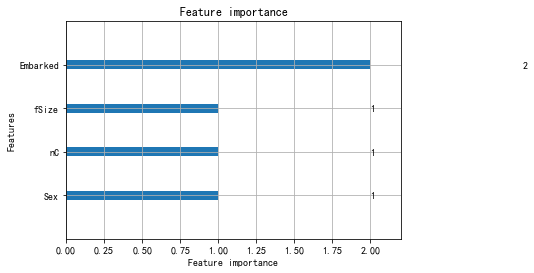

Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
Training until validation scores don't improve for 50 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	

C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


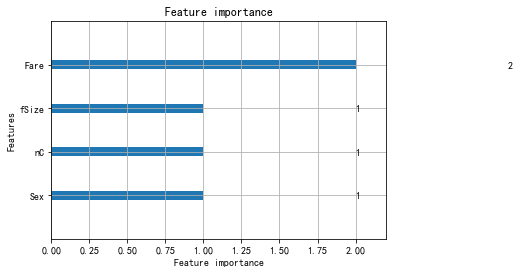

Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1

C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


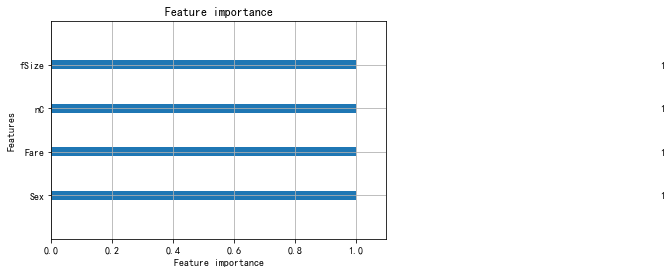

Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
Training until validation scores don't improve for 50 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[20]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[24]	traini

C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\20943\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


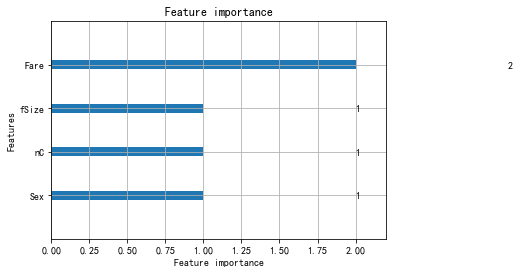

In [18]:
# Kit k models with early-stopping on different training/validation splits
k = 4
predsValid = 0
predsTrain = 0
predsTest = 0
for i in range(0, k):
    print('Fitting model', k)

    # Prepare the data set for fold
    trainData, validData = train_test_split(train,
                                            test_size=0.4,
                                            stratify=train.Survived)
    trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    # Train
    gbm = lgb.train(params,
                    trainDataL,
                    100000,
                    valid_sets=[trainDataL, validDataL],
                    early_stopping_rounds=50,
                    verbose_eval=4)

    # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

In [20]:
# Predict
predsValid += gbm.predict(validData,
                              num_iteration=gbm.best_iteration)/k
predsTrain += gbm.predict(trainData,
                              num_iteration=gbm.best_iteration)/k
redsTest += gbm.predict(testData,
                             num_iteration=gbm.best_iteration)/k

# Print assessment
# assessMod(predsTrain, trainLabels, predsValid=predsValid, yValid= validLabels,
#           report=True, plot=True)

# Save submission
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = np.int32(predsTest > 0.5)
sub.to_csv('sub2.csv',
           index=False)

NameError: name 'redsTest' is not defined